In [38]:
#  Importing libraries and declaring variables
import pandas as pd
import numpy as np
from tqdm import tqdm
import statistics as sta
from shapely.geometry import Polygon as pg
import os


# Declaration of dictionaries
dict_drifting_long = {}
dict_fix_gear = {}
dict_purse_seine = {}
dict_trawlers = {}
dict_trollers = {}

# declaring file location
csv_file_loc = '/Users/vitthal/Documents/GitHub/marine-enhancement/Data/raw'


chunk_size = 1000


# List of df csv imports
df_frame_dict = [dict_trawlers, dict_drifting_long, dict_trollers,
                 dict_fix_gear,  dict_purse_seine]

#  Declation for columns
headers = ['mmsi', 'mean_speed', 'sd_speed', 'mean_course', 'sd_course', 'mean_dis_port', 'mean_dis_shore',
           'area_covered', 'log_dis_shore', 'log_speed', 'log_dis_port' , 'mul_log_dis_shore_speed', 'mul_log_dis_port_speed', 'mul_dis_shore_speed']


# Declaring dataframs for features
df_drifting_long_features = pd.DataFrame(columns=headers)
df_fix_gear_features = pd.DataFrame(columns=headers)
df_purse_seine_features = pd.DataFrame(columns=headers)
df_trawlers_features = pd.DataFrame(columns=headers)
df_trollers_features = pd.DataFrame(columns=headers)

# List of dataframes for features
df_feature_list =[df_trawlers_features, df_drifting_long_features, df_trollers_features, df_fix_gear_features, df_purse_seine_features  ]

# Feature Engineering

1. Derive mean and standard deviation from the boat speeds and course, this will be unique to a single boat mmsi
2. Compute mean from the avarage distance from the shore and distance from the port
3. Compute area covered by the boat throughout the movement.
4. Interaction of multiply features such as speed and distance (algaebric multiplication of multiple features and appending it to a data frame.)
5. Eleminate skewness in features such as distances, but taking logarithm of the features.


In [39]:
# Function Definition ---> Creating dictionary based on the features
def create_dict(df_boat_type, dict_boat_type):
    dict_boat_type = {}
    for i in tqdm(range(len(df_boat_type['mmsi']))):
        # Adding the keys (mmsi) to the dictionary
        try:
            mmsi = df_boat_type['mmsi'][i]
            # append all the keys to the dictionary using the unique mmsi
            # dict_boat_type.keys(df_boat_type['mmsi'].unique())

            if mmsi not in dict_boat_type.keys():
                dict_boat_type[mmsi] = {}
                dict_boat_type[mmsi]['coordinates'] = []
                dict_boat_type[mmsi]['timestamp'] = []
                dict_boat_type[mmsi]['speed'] = []
                dict_boat_type[mmsi]['course'] = []
                dict_boat_type[mmsi]['distance_from_shore'] = []
                dict_boat_type[mmsi]['distance_from_port'] = []
            # Appending data to the dictionary
            dict_boat_type[mmsi]['coordinates'].append(
                (df_boat_type['lat'][i], df_boat_type['lon'][i]))
            dict_boat_type[mmsi]['timestamp'].append(
                df_boat_type['timestamp'][i])
            dict_boat_type[mmsi]['speed'].append(df_boat_type['speed'][i])
            dict_boat_type[mmsi]['course'].append(df_boat_type['course'][i])
            dict_boat_type[mmsi]['distance_from_shore'].append(
                df_boat_type['distance_from_shore'][i])
            dict_boat_type[mmsi]['distance_from_port'].append(
                df_boat_type['distance_from_port'][i])
        except Exception as e:
            print(f'Error in creating dictionary: {e}')
    print(f'Length of the dictionary is {len(dict_boat_type)}')
    return dict_boat_type

In [40]:
# Function Definition ---> Creating features based on the dictionary


def feature_generation(df_boat_type_features, dict_boat_type):
    features_list = []
    print('Creating features')
    try:
        for mmsi in tqdm(dict_boat_type.keys()):
            # Epsilon to avoid infinite values
            epsilon = 1e-6

            # Mean of speed
            mean_speed = np.nanmean(dict_boat_type[mmsi]['speed'])

            # Standard Deviation
            sd_speed = np.nanstd(dict_boat_type[mmsi]['speed'])

            # Mean Course
            mean_course = np.nanmean(dict_boat_type[mmsi]['course'])

            # Standard Deviation
            sd_course = np.nanstd(dict_boat_type[mmsi]['course'])

            # Mean of distance from port
            mean_dis_port = np.nanmean(
                dict_boat_type[mmsi]['distance_from_port'])

            # Mean of distance from shore
            mean_dis_shore = np.nanmean(
                dict_boat_type[mmsi]['distance_from_shore'])

            # Area covered by the boat
            ship_polygon = pg(dict_boat_type[mmsi]['coordinates'])
            area_covered = ship_polygon.area

            # Taking logarithms of key metric data and multiplying, also adding epsilon to eliminate infinite values
            log_dis_shore = np.nanmean(
                np.log(np.array(dict_boat_type[mmsi]['distance_from_shore']) + epsilon))
            log_speed = np.nanmean(
                np.log(np.array(dict_boat_type[mmsi]['speed']) + epsilon))
            mul_log_dis_shore_speed = log_dis_shore * log_speed

            log_dis_port = np.nanmean(
                np.log(np.array(dict_boat_type[mmsi]['distance_from_port']) + epsilon))
            mul_log_dis_port_speed = log_dis_port * log_speed

            # Multiplying speed and distance from shore and port without log transformation, replacing zero values with 1
            mul_dis_shore_speed = np.nanmean(
                np.where(np.array(dict_boat_type[mmsi]['distance_from_shore']) != 0,
                         np.array(dict_boat_type[mmsi]['distance_from_shore']) *
                         np.array(dict_boat_type[mmsi]['speed']),
                         1))

            # Create a dictionary for the row with the feature values
            row_dict = {
                'mmsi': mmsi,
                'mean_speed': mean_speed,
                'sd_speed': sd_speed,
                'mean_course': mean_course,
                'sd_course': sd_course,
                'mean_dis_port': mean_dis_port,
                'mean_dis_shore': mean_dis_shore,
                'area_covered': area_covered,
                'log_dis_shore': log_dis_shore,
                'log_speed': log_speed,
                'log_dis_port': log_dis_port,
                'mul_log_dis_shore_speed': mul_log_dis_shore_speed,
                'mul_log_dis_port_speed': mul_log_dis_port_speed,
                'mul_dis_shore_speed': mul_dis_shore_speed
            }

            # Append the dictionary to the features list
            features_list.append(row_dict)
    except Exception as e:
        print(f'Error in creating features: {e}')

    # Append the data from the features list to the dataframe
    df_boat_type_features = pd.concat([df_boat_type_features, pd.DataFrame(features_list)])
    return df_boat_type_features

In [41]:
# Main cell to invoke functions

# Creating dictionaries for all the boat types
final_df = pd.DataFrame()

csv_dir = os.listdir(csv_file_loc)
if '.DS_store' in csv_dir:
    csv_dir.remove('.DS_store')

for csv_file, i in zip(csv_dir, range(len(df_frame_dict))):
    if csv_file.endswith('.csv'):
        file_path = os.path.join(csv_file_loc, csv_file)
        df_boat_type = pd.read_csv(file_path)
        print(f'Processing {csv_file} with size {len(df_boat_type)}')
        # Creating dictionary for the boat type
        df_frame_dict[i] = create_dict(df_boat_type, df_frame_dict[i])
        # Creating features for the boat type
        df_feature_list[i] = feature_generation(df_feature_list[i], df_frame_dict[i])
        del df_boat_type



Processing trawlers.csv with size 4369101


100%|██████████| 4369101/4369101 [01:52<00:00, 38710.71it/s]


Length of the dictionary is 49
Creating features


100%|██████████| 49/49 [00:27<00:00,  1.81it/s]


Processing drifting_longlines.csv with size 13968727


100%|██████████| 13968727/13968727 [05:48<00:00, 40038.55it/s]


Length of the dictionary is 110
Creating features


100%|██████████| 110/110 [16:52<00:00,  9.20s/it]


Processing trollers.csv with size 166243


100%|██████████| 166243/166243 [00:03<00:00, 52313.07it/s]


Length of the dictionary is 5
Creating features


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Processing fixed_gear.csv with size 1559137


100%|██████████| 1559137/1559137 [00:29<00:00, 52048.14it/s]


Length of the dictionary is 36
Creating features


100%|██████████| 36/36 [01:18<00:00,  2.18s/it]


Processing purse_seines.csv with size 1545323


100%|██████████| 1545323/1545323 [00:29<00:00, 51512.23it/s]


Length of the dictionary is 28
Creating features


100%|██████████| 28/28 [01:23<00:00,  2.99s/it]


In [51]:
# Stiching all the dataframes and adding a unique identifier to each dataframe

df_stiched = pd.DataFrame(columns = headers)
for i in range(len(df_feature_list)):
    df_feature_list[i]['unique_id'] = i
    df_stiched = pd.concat([df_stiched, df_feature_list[i]])

print(df_stiched.describe)

<bound method NDFrame.describe of             mmsi  mean_speed  sd_speed  mean_course   sd_course  \
0   1.252340e+12    2.832586  4.649472   182.270427  118.752408   
1   5.145483e+12    1.249238  2.214813   220.598183  104.977158   
2   1.985955e+13    0.744803  2.029596   234.488085   86.170132   
3   3.491170e+13    1.538317  2.506843   146.193885  124.886371   
4   5.110130e+13    2.103552  2.662536   212.084623  101.589559   
..           ...         ...       ...          ...         ...   
23  1.583170e+14    4.236311  3.601373   253.134107  117.253832   
24  1.785557e+14    5.415183  5.611893   161.895488  105.210378   
25  2.679667e+14    4.512628  3.916014   183.189171  111.180086   
26  3.832297e+13    5.534084  5.783453   192.373724   98.687173   
27  4.393595e+13    5.736315  5.740804   178.466250  105.357088   

    mean_dis_port  mean_dis_shore  area_covered  log_dis_shore  log_speed  \
0    44072.984259    31216.217811    158.569940      -4.240884  -7.969092   
1    78

In [52]:
# Saving the dataframe to a csv file

df_stiched.to_csv('../Data/raw/boat_type_features.csv', index=False)


# Feature Selection

The model trained wiothout any feature selection resulted in a very low accuracy (acc : 0.5434782608695652, hamming_loss : 0.45652173913043476) . Therefore, we decided to use feature selection to reduce the number of features. We used the following feature selection methods:

1. Recursive Feature Elimination (RFE)
2. SelectKBest
3. SelectFromModel

The results of the feature selection methods are as follows:


<AxesSubplot:>

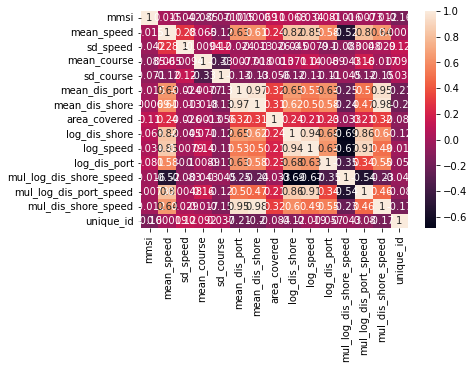

In [56]:
import seaborn as sns
# Implementing correleation analysis

corr = df_stiched.corr()
# print(corr)
# corr.to_csv('../Data/raw/correlation.csv', index=False)
#  creating heatmap for correlation
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)





In [65]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Separating the features from the dataframe
features = ['mean_speed', 'sd_speed', 'mean_course', 'sd_course', 'mean_dis_port', 'mean_dis_shore', 'area_covered',
            'log_dis_shore', 'log_speed', 'log_dis_port', 'mul_log_dis_shore_speed', 'mul_log_dis_port_speed', 'mul_dis_shore_speed']
x = df_stiched.loc[:, features].values

# Separating out the target
y = df_stiched.loc[:, ['unique_id']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

# Applying PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(x)

# Creating a new dataframe for the principal components
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

# Resetting the index of the df_stiched dataframe
df_stiched_reset = df_stiched.reset_index(drop=True)

# Concatenating the principal components with the target variable
df_pca['unique_id'] = df_stiched_reset['unique_id']

# Printing the explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Saving the dataframe to a csv file
df_pca.to_csv('../Data/csv/boat_type_pca.csv', index=False)


Explained Variance Ratio: [0.4730841  0.12903284 0.10511764]
